In [1]:
import sys
sys.path.append('../src/wadiroscnn')
import hyperopt as hp
import numpy as np
import scipy as sc
import models as hm
import benchmark_functions as bf
import uci_datasets as uci
import benchmarking_functions as bench
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import mlflow
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from datetime import datetime
import torch.nn as nn
import cvxpy as cp
import mlflow.pytorch
from mlflow.models.signature import infer_signature, set_signature
import hyperopt
from functools import partial
import pandas as pd
import seaborn as sns

In [2]:
#uci.all_datasets


First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# Create a new MLflow Experiment
experiment = mlflow.set_experiment("stability_wadiroscnn_uci_unscaled")

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Experiment_id: 222501670559945861
Artifact Location: mlflow-artifacts:/222501670559945861
Name: stability_wadiroscnn_uci_unscaled
Tags: {}
Lifecycle_stage: active


In [4]:
search_space_wadiro = {'radius': hp.choice('radius', [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4]),
                'max_neurons': hp.choice('max_neurons', [2,3, 4,5, 6,7, 8,9, 10,11, 12,13, 14,15, 16,17, 18,19, 20, 21,22,23, 24,25, 26,27, 28,29, 30]),
                #'wasserstein': hp.choice('wasserstein', ["l2"]),
                }

In [5]:
rng = np.random.default_rng(42)

solver_name = "MOSEK"
verbose = False
bound_type ='squared_norm'
bigM1 = 20
bigM2 = 1e2
bigM3 = 20
bound_eps = 0.001
wasserstein = "l2"

DATASET_LIST = [ 
	'energy', 'forest', 'solar', 'concrete', 'stock', 'housing'    
	]
# concrete: https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength
# energy: https://archive.ics.uci.edu/dataset/242/energy+efficiency
# forest: https://archive.ics.uci.edu/dataset/162/forest+fires
# housing: https://www.kaggle.com/code/satoru90/boston-housing-dataset-regression
# solar: https://archive.ics.uci.edu/dataset/89/solar+flare ?
# stock: https://archive.ics.uci.edu/dataset/247/istanbul+stock+exchange

In [6]:
for dataset_name in DATASET_LIST:
    #data = bench.dataset_wrapper(benchmark_func=benchmark_func[0], n_dim=benchmark_func[1], rng =rng, N = N, train_size=train_size, test_size=test_size)
    # import data
    uci_data = uci.Dataset(dataset_name)
    X_train, Y_train, X_test, Y_test = uci_data.get_split()

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    # Fit and transform the features
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    Y_train_scaled = scaler_y.fit_transform(Y_train)
    Y_test_scaled = scaler_y.transform(Y_test)

    data = {"X_train": X_train, "Y_train": Y_train, "X_test": X_test, "Y_test": Y_test, "X_train_scaled": X_train_scaled, "Y_train_scaled": Y_train_scaled, "X_test_scaled": X_test_scaled, "Y_test_scaled": Y_test_scaled, 'scaler_y': scaler_y, 'scaler_x': scaler_x}
   
    #data.generate_data_wasserstein_corrupt_both(corrupt_data_points= n_corrupted_points, min_distance=0.05, n_projections=100, k_multiplier=1.5, L=2, seed=42)


    print(f"WaDiRO SCNN on {dataset_name}: \n")
    fmin_wadiro = partial(bench.stability_objective_scnn, data = data, solver_name=solver_name, experiment=experiment, wasserstein = wasserstein, dataset_name=dataset_name, verbose=verbose, bound_eps=bound_eps, bound_type=bound_type, bigM1=bigM1, bigM2=bigM2, bigM3=bigM3)
    argmin_wadiro = fmin(fn=fmin_wadiro,
              space=search_space_wadiro,
              algo= partial(bench.suggest, nbMaxSucessiveFailures=1000), #hyperopt.tpe.suggest, # try anneal.suggest
              max_evals=np.inf) #trials=spark_trials)
    


energy dataset, N=768, d=8
WaDiRO SCNN on energy: 

------start of trial: ------         
radius= 10.0, max_neurons = 14, bias = True
Training duration: 0:00:02.304230    
------start of trial: ------                               
radius= 1e-06, max_neurons = 7, bias = True                
Training duration: 0:00:01.762056                          
------start of trial: ------                               
radius= 1000.0, max_neurons = 30, bias = True              
Training duration: 0:00:04.103244                          
------start of trial: ------                               
radius= 100.0, max_neurons = 18, bias = True               
Training duration: 0:00:02.555138                          
------start of trial: ------                               
radius= 0.0001, max_neurons = 4, bias = True               
Training duration: 0:00:01.382682                          
------start of trial: ------                               
radius= 1000.0, max_neurons = 8, bias = True    

# extract results and figures

In [7]:
df = mlflow.search_runs([experiment.experiment_id])

display(df)


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.RMSE_train,metrics.stability,metrics.MAE_test,metrics.MAE_train,...,params.bias,params.training time,params.dataset,params.eps,params.bigM1,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.model_name,tags.mlflow.source.name
0,46e95cea04a84cc29928bd6bc1a01973,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/46e95cea0...,2024-11-19 05:57:22.888000+00:00,2024-11-19 05:57:24.763000+00:00,3.564800,0.038161,2.720025,2.046654,...,True,0:00:01.291344,housing,[[1.26906525e-04 6.17127314e-03 7.33870711e-04...,20,julien,LOCAL,peaceful-ram-472,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
1,7cdd7b2eadcf41ec8d82dda7335c93fa,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/7cdd7b2ea...,2024-11-19 05:57:19+00:00,2024-11-19 05:57:22.859000+00:00,7.091553,0.004501,3.215437,4.582940,...,True,0:00:02.663550,housing,[[8.17329208e-04 3.44764757e-03 2.26003583e-03...,20,julien,LOCAL,intrigued-colt-644,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
2,0a0872122c9b49bd84e92c42b348c7c5,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/0a0872122...,2024-11-19 05:57:17.065000+00:00,2024-11-19 05:57:18.972000+00:00,3.649885,0.015310,2.635876,2.046950,...,True,0:00:01.288218,housing,[[1.08221582e-03 7.58666589e-03 7.09459650e-04...,20,julien,LOCAL,beautiful-squid-876,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
3,b6e70e98cad248688661e859c99a89c5,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/b6e70e98c...,2024-11-19 05:57:15.776000+00:00,2024-11-19 05:57:17.050000+00:00,5.176553,0.009533,3.145242,3.390228,...,True,0:00:00.921445,housing,[[8.18702717e-04 8.70753509e-04 1.50178446e-03...,20,julien,LOCAL,classy-wolf-260,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
4,2cc7a49869d14c3fb168020647f17922,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/2cc7a4986...,2024-11-19 05:57:12.953000+00:00,2024-11-19 05:57:15.760000+00:00,2.887335,0.018870,3.405946,1.430617,...,True,0:00:01.946347,housing,[[2.03041403e-05 6.06040573e-04 6.08581360e-04...,20,julien,LOCAL,upset-newt-718,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,2fea47beafc648e2901c40b0a60d395b,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/2fea47bea...,2024-11-19 03:58:03.513000+00:00,2024-11-19 03:58:05.172000+00:00,5.535302,0.015316,3.300342,3.457203,...,True,0:00:01.382682,energy,[[4.98706547e-05 1.92205370e-02 1.51574494e-02...,20,julien,LOCAL,nimble-kit-174,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
2257,236d9fa30332494dad8aecb98cdd87da,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/236d9fa30...,2024-11-19 03:58:00.461000+00:00,2024-11-19 03:58:03.502000+00:00,9.991850,0.000123,9.105107,9.024127,...,True,0:00:02.555138,energy,[[2.40037202e-05 5.42220246e-02 5.06307915e-04...,20,julien,LOCAL,painted-shrew-802,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
2258,2e9bc8aa9b4d40bfb10f4c3a420c8093,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/2e9bc8aa9...,2024-11-19 03:57:55.541000+00:00,2024-11-19 03:58:00.450000+00:00,10.060086,NaN,9.178915,9.108616,...,True,0:00:04.103244,energy,nan,20,julien,LOCAL,redolent-crow-79,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...
2259,26868eaee2ce4fda804f72fb5d57869c,222501670559945861,FINISHED,mlflow-artifacts:/222501670559945861/26868eaee...,2024-11-19 03:57:53.434000+00:00,2024-11-19 03:57:55.529000+00:00,1.476017,504.175721,0.885488,0.916699,...,True,0:00:01.762056,energy,[[6.98867744e-07 3.02912414e-02 1.02789791e-02...,20,julien,LOCAL,charming-lark-356,wadiro_scnn_l2,/home/julien/.local/lib/python3.10/site-packag...


In [27]:
datasets = ['energy', 'solar', 'concrete', 'stock', 'housing', 'forest']
print(datasets)
models = ['wadiro_scnn_l2']

['energy', 'solar', 'concrete', 'stock', 'housing', 'forest']


energy
(13, 29)
(13,) (29,)


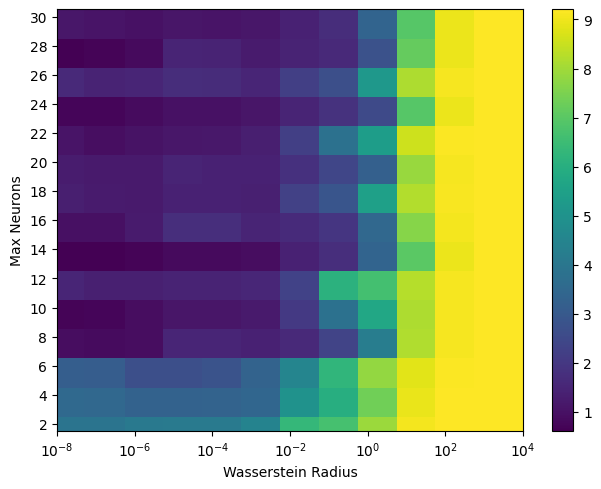

(13, 29)
(13,) (29,)


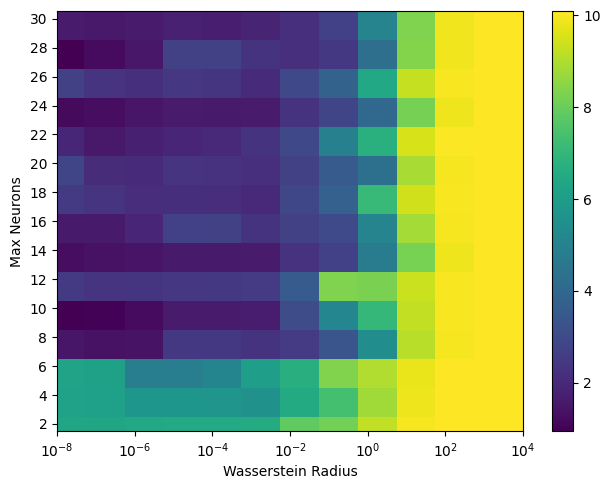

(13, 25)
(13,) (25,)


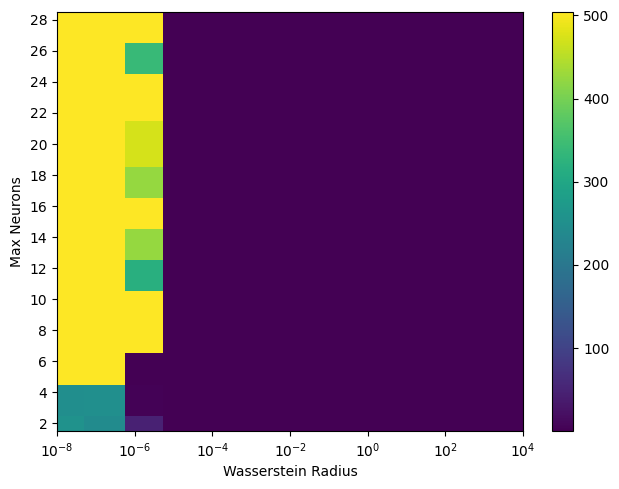

solar
(13, 29)
(13,) (29,)


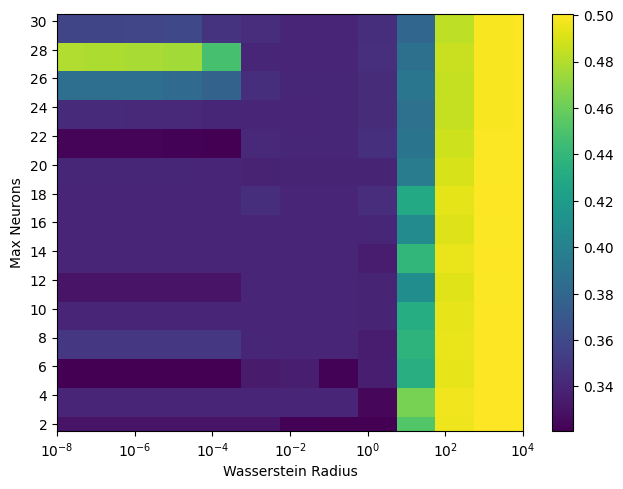

(13, 29)
(13,) (29,)


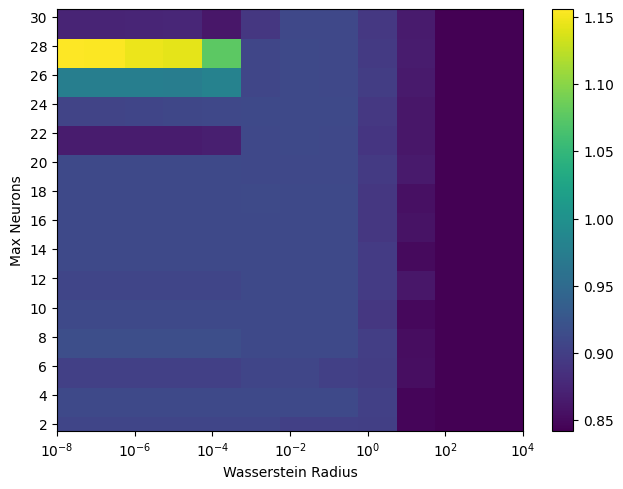

(13, 29)
(13,) (29,)


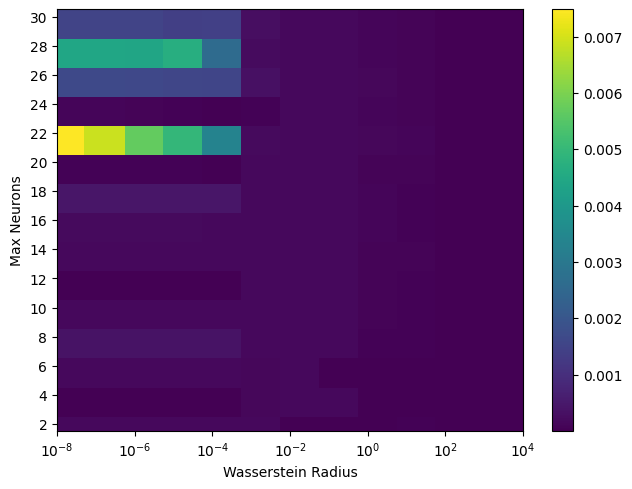

concrete
(13, 29)
(13,) (29,)


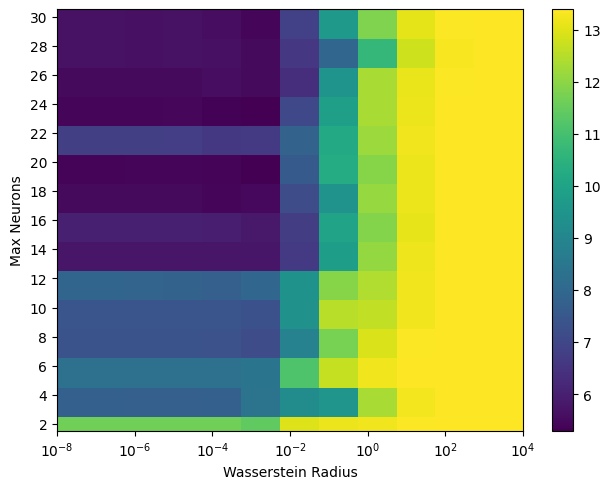

(13, 29)
(13,) (29,)


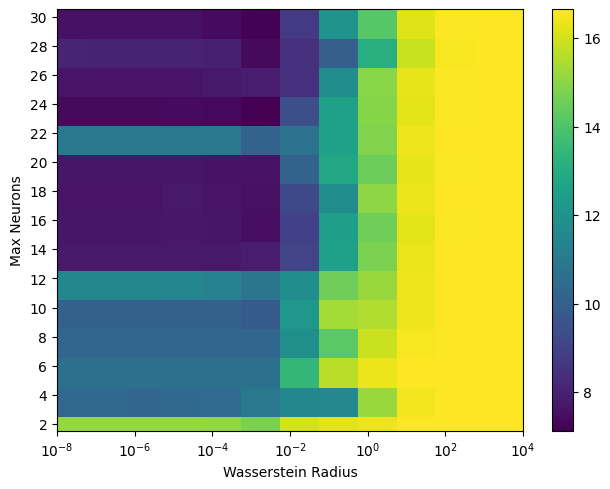

(13, 27)
(13,) (27,)


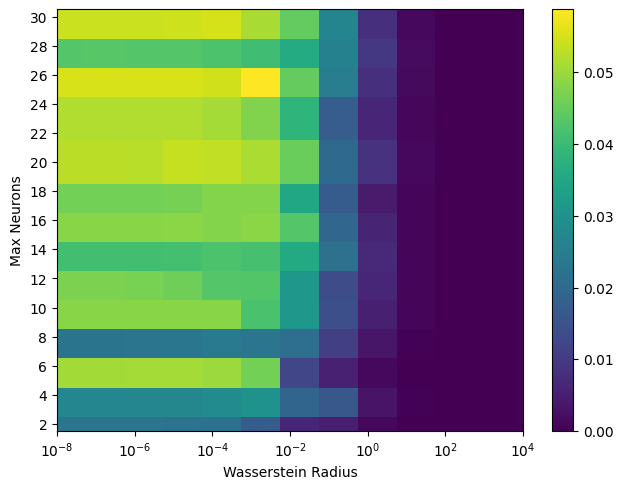

stock
(13, 29)
(13,) (29,)


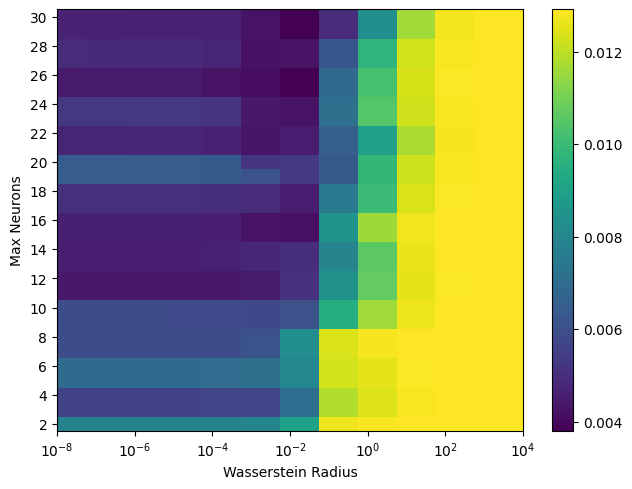

(13, 29)
(13,) (29,)


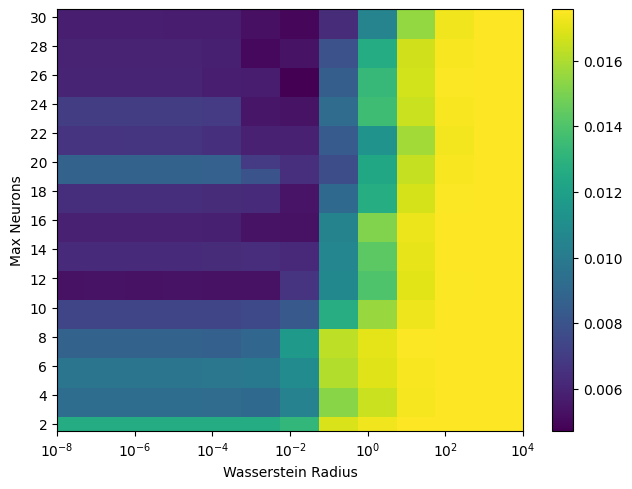

(13, 29)
(13,) (29,)


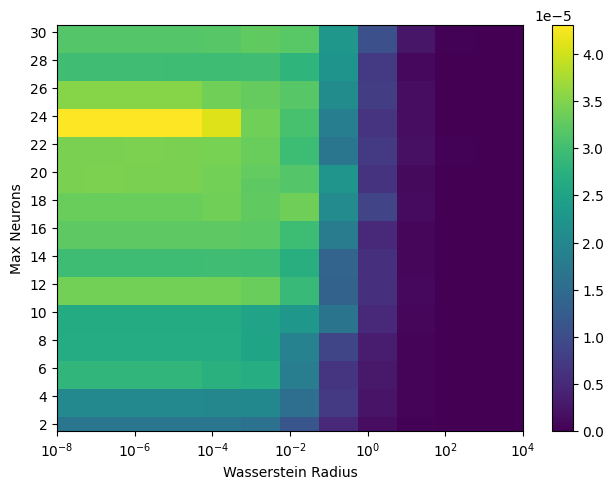

housing
(13, 29)
(13,) (29,)


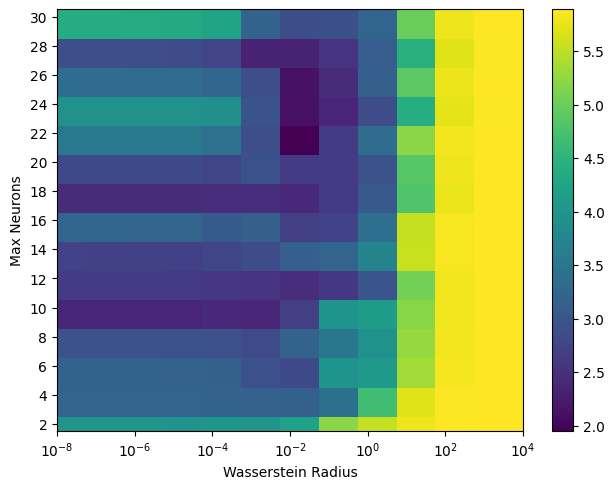

(13, 29)
(13,) (29,)


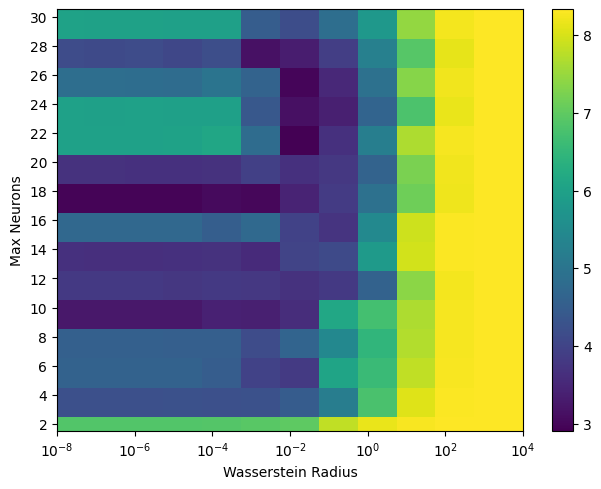

(13, 29)
(13,) (29,)


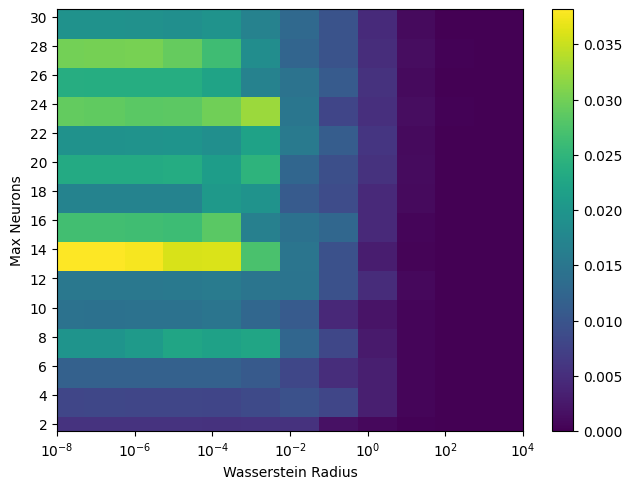

forest
(13, 29)
(13,) (29,)


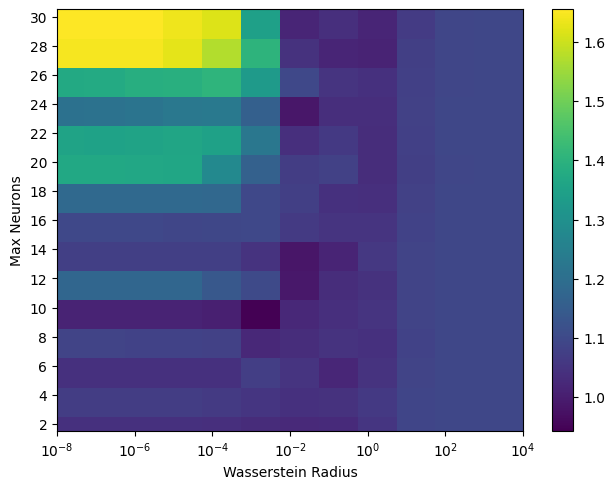

(13, 29)
(13,) (29,)


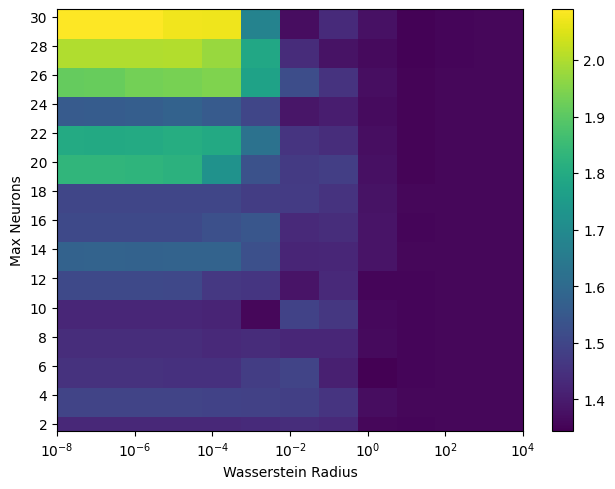

(13, 29)
(13,) (29,)


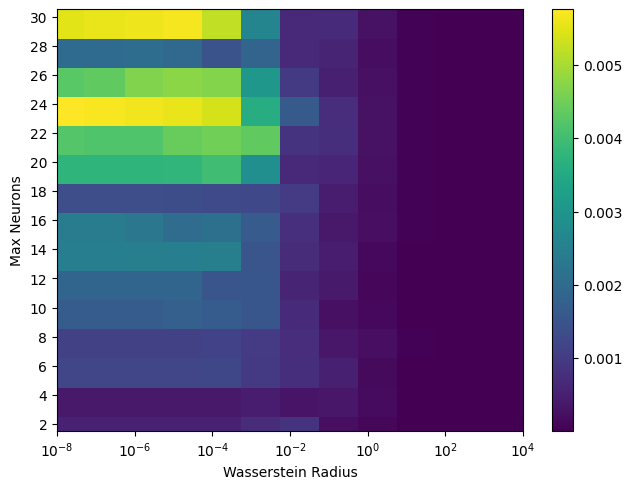

In [28]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
def findxyind(xval, yval, xarray, yarray):       
    for index in range(xarray.shape[0]):
        if xarray[index]==xval and yarray[index]==yval:
            return index
    return None


metrics = ['metrics.MAE_test', 'metrics.RMSE_test', 'metrics.stability']

for dataset_name in datasets:
    print(dataset_name)
    for model in models:
        for metric in metrics:
            data_plot = df.loc[(df['params.dataset'] == dataset_name) & (df['tags.model_name'] == model) & (df[metric].notna())][[metric, 'params.radius', 'params.max_neurons']]
            #display(data_plot)
            
            x = data_plot['params.radius'].values.astype(float)
            x_min = x.min()
            x_max = x.max()
            y = data_plot['params.max_neurons'].values.astype(float)
            y_min = y.min()
            y_max = y.max()
            z = data_plot[metric].values.astype(float)
            z_min = z.min()
            z_max = z.max()
            
            z = np.asarray(z)
            x=np.asarray(x)
            y=np.asarray(y)
            xunique=np.unique(x)
            yunique=np.unique(y)

            zarray=np.empty([xunique.shape[0], yunique.shape[0]])
            
            for i in range(xunique.shape[0]):
                for j in range(yunique.shape[0]):
                    xval=xunique[i]
                    yval=yunique[j]
                    index=findxyind(xval, yval, x, y)
                    zarray[i,j]=z[index] if index is not None else np.nan
            zarray_df = pd.DataFrame(zarray)
            zarray_df = zarray_df.interpolate(method='linear', axis=1, limit_direction="both")
            zarray = zarray_df.values.reshape(zarray.shape)
            print(zarray.shape)
           
            print(xunique.shape, yunique.shape)
            X, Y = np.meshgrid(xunique, yunique, indexing='ij')
            plt.pcolormesh(X, Y, zarray, shading='nearest')
            plt.colorbar()
            plt.xscale('log')
            plt.xlim(1e-8, x_max)
            plt.tight_layout()
            plt.xlabel("Wasserstein Radius")
            plt.yticks(np.arange(y_min, y_max+2, 2))
            plt.ylabel("Max Neurons")
            #plt.title(f"{dataset_name}: {metric}")
            plt.savefig(f"./resultats/{dataset_name}_{metric[8:]}.pdf",bbox_inches='tight',dpi=600)
            plt.show()
            